In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os

In [2]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [3]:
N_head = 5 # first 5 lines are head lines, not include data
N_column = 4+2

# Nx = 36
# Ny = 21
# Nz = 5
# N_parcel = 3780

Nx = 24
Ny = 21
Nz = 6
N_parcel = Nx*Ny*Nz

if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')
    

directory = './Lifetime/'
filename = "Lifetime_"+Years[0]+Months[0]+Days[0]+".txt"
print(directory+filename)

./Lifetime/Lifetime_20000101.txt


In [4]:
N_year  = len(Years)
N_month = len(Months)
N_day   = len(Days)

lifetime   = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_N = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_S = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

lifetime.shape

(6, 21, 24, 10, 12, 10)

In [5]:
for i_year in range(N_year):
    for i_month in tqdm(range(N_month)):
        for i_day in range(N_day):
            directory = './Lifetime/'
            filename = "Lifetime_"+Years[i_year]+Months[i_month]+Days[i_day]+".txt"
            File = open(directory+filename, 'r')
        
            Lines = File.readlines()

            # Strips the newline character
            data = []
            data_N = []
            data_S = []
            for line in Lines:
                a = line.split(',')
                data.append(float(a[0])) # total lifetime
                data_N.append(float(a[1]))
                data_S.append(float(a[2]))
    
    
            i = 0
            for ix in range(Nx):
                for iy in range(Ny):
                    for iz in range(Nz):
                        lifetime[iz,iy,ix,i_day,i_month,i_year] = data[i]
                        lifetime_N[iz,iy,ix,i_day,i_month,i_year] = data_N[i]
                        lifetime_S[iz,iy,ix,i_day,i_month,i_year] = data_S[i]
                        
                        i = i+1
                        

100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


In [6]:
###
# Calculate monthly mean data
###

# lifetime # [Nz, Ny, Nx, N_day, N_month, N_year]

lifetime_month  = np.mean(lifetime, axis=3)
lifetime_month2 = np.zeros((Nz, Ny, Nx, N_month*N_year))

lifetime_month_N  = np.mean(lifetime_N, axis=3)
lifetime_month2_N = np.zeros((Nz, Ny, Nx, N_month*N_year))

lifetime_month_S  = np.mean(lifetime_S, axis=3)
lifetime_month2_S = np.zeros((Nz, Ny, Nx, N_month*N_year))

for i_year in range(N_year):
    for i_month in range(N_month):
        lifetime_month2[:, :, :, i_month+i_year*N_month] = lifetime_month[:, :, :, i_month, i_year]
        lifetime_month2_N[:, :, :, i_month+i_year*N_month] = lifetime_month_N[:, :, :, i_month, i_year]
        lifetime_month2_S[:, :, :, i_month+i_year*N_month] = lifetime_month_S[:, :, :, i_month, i_year]

###
# calculate seasonal mean data
###

lifetime_season2   = np.zeros((Nz, Ny, Nx, 4*N_year))
lifetime_season2_N = np.zeros((Nz, Ny, Nx, 4*N_year))
lifetime_season2_S = np.zeros((Nz, Ny, Nx, 4*N_year))

for i_season in range(4*N_year-1):
#     print(i_season*3+2, (i_season+1)*3+2)
    lifetime_season2[:,:,:,i_season] = \
    np.mean(lifetime_month2[:,:,:,i_season*3+2:(i_season+1)*3+2], axis=3)
    
    lifetime_season2_N[:,:,:,i_season] = \
    np.mean(lifetime_month2_N[:,:,:,i_season*3+2:(i_season+1)*3+2], axis=3)
    
    lifetime_season2_S[:,:,:,i_season] = \
    np.mean(lifetime_month2_S[:,:,:,i_season*3+2:(i_season+1)*3+2], axis=3)    
    
    
lifetime_season2[:,:,:,4*N_year-1] = ( lifetime_month2[:,:,:,4*N_year-1]
                                      +lifetime_month2[:,:,:,0]
                                      +lifetime_month2[:,:,:,1])/3

lifetime_season2_N[:,:,:,4*N_year-1] = ( lifetime_month2_N[:,:,:,4*N_year-1]
                                        +lifetime_month2_N[:,:,:,0]
                                        +lifetime_month2_N[:,:,:,1])/3

lifetime_season2_S[:,:,:,4*N_year-1] = ( lifetime_month2_S[:,:,:,4*N_year-1]
                                        +lifetime_month2_S[:,:,:,0]
                                        +lifetime_month2_S[:,:,:,1])/3


lifetime_season   = np.zeros((Nz, Ny, Nx, 4, N_year))
lifetime_season_N = np.zeros((Nz, Ny, Nx, 4, N_year))
lifetime_season_S = np.zeros((Nz, Ny, Nx, 4, N_year))

for i_year in range(N_year):
    for i_season in range(4):
        lifetime_season[:,:,:,i_season,i_year]   = lifetime_season2[:,:,:,i_season+i_year*4]
        lifetime_season_N[:,:,:,i_season,i_year] = lifetime_season2_N[:,:,:,i_season+i_year*4]
        lifetime_season_S[:,:,:,i_season,i_year] = lifetime_season2_S[:,:,:,i_season+i_year*4]

In [7]:
N_month*N_year

120

In [9]:
# select best injection location (lon,lat) at the same time

lifetime_mean = np.mean(lifetime, axis=(1,2,3,4,5))
lifetime_GlobalMean = np.mean(lifetime, axis=(1,2))
print(lifetime_GlobalMean.shape)
lifetime_std = np.std(lifetime_GlobalMean, axis=(1,2,3))

lifetime_q50 = np.percentile(lifetime_GlobalMean, 25, axis=(1,2,3))
print(lifetime_std.shape)

# Top 10% mean: calculate top 10% mean for each month in each year at each injection height
Life_top = np.zeros((Nz, 4))
Life_top_N   = np.zeros((Nz, 4))
Life_top_S   = np.zeros((Nz, 4))


Life   = np.zeros((Nz, 4))
Life_N = np.zeros((Nz, 4))
Life_S = np.zeros((Nz, 4))


lifetime_SeasonMean   = np.mean(lifetime_season, axis=4)
lifetime_SeasonMean_N = np.mean(lifetime_season_N, axis=4)
lifetime_SeasonMean_S = np.mean(lifetime_season_S, axis=4)

print("lifetime_SeasonMean.shape:", lifetime_SeasonMean.shape)

for iz in range(Nz):
    for i_season in range(4):
            a   = lifetime_SeasonMean[iz,:,:,i_season].flatten()
            a_N = lifetime_SeasonMean_N[iz,:,:,i_season].flatten()
            a_S = lifetime_SeasonMean_S[iz,:,:,i_season].flatten()
            
            # top 10%
            idx = np.argsort(a)
            Num = int(len(a)*0.1)
            Life_top[iz,i_season]   = np.mean(a[idx[-Num:-1]])
            Life_top_N[iz,i_season] = np.mean(a_N[idx[-Num:-1]])
            Life_top_S[iz,i_season] = np.mean(a_S[idx[-Num:-1]])
            
            # all average
            Life[iz,i_season]   = np.mean(a)
            Life_N[iz,i_season] = np.mean(a_N)
            Life_S[iz,i_season] = np.mean(a_S)
            

print("Life_top.shape: ", Life_top.shape)

Life_Z_TopMean = np.mean(Life_top, axis=(1))

(6, 10, 12, 10)
(6,)
lifetime_SeasonMean.shape: (6, 21, 24, 4)
Life_top.shape:  (6, 4)


In [10]:
# select best injection location (lon,lat) at the same time

lifetime_mean = np.mean(lifetime, axis=(1,2,3,4,5))
lifetime_GlobalMean = np.mean(lifetime, axis=(1,2))
print(lifetime_GlobalMean.shape)
lifetime_std = np.std(lifetime_GlobalMean, axis=(1,2,3))

lifetime_q50 = np.percentile(lifetime_GlobalMean, 25, axis=(1,2,3))
print(lifetime_std.shape)

# Top 10% mean: calculate top 10% mean for each month in each year at each injection height
Life_top30_lat = np.zeros((Nz, 4))
Life_top30_lat_N = np.zeros((Nz, 4))
Life_top30_lat_S = np.zeros((Nz, 4))

Life_top30_lat_lon = np.zeros((Nz, 4))
Life_top30_lat_lon_N = np.zeros((Nz, 4))
Life_top30_lat_lon_S = np.zeros((Nz, 4))



lifetime_SeasonMean = np.mean( lifetime_season, axis=4 )
lifetime_SeasonMean = np.mean( lifetime_season_N, axis=4 )
lifetime_SeasonMean = np.mean( lifetime_season_S, axis=4 )

lifetime_SeasonMean_LonMean   = np.mean( lifetime_season, axis=(2,4) )
lifetime_SeasonMean_LonMean_N = np.mean( lifetime_season_N, axis=(2,4) )
lifetime_SeasonMean_LonMean_S = np.mean( lifetime_season_S, axis=(2,4) )


print("lifetime_SeasonMean.shape:", lifetime_SeasonMean.shape)

for iz in range(Nz):
    for i_season in range(4):
        a   = lifetime_SeasonMean_LonMean[iz,:,i_season]
        a_N = lifetime_SeasonMean_LonMean_N[iz,:,i_season]
        a_S = lifetime_SeasonMean_LonMean_S[iz,:,i_season]
    
    
        percent = 0.3
        
        # top 30% for lat
        idx = np.argsort(a)
        print(idx)
        print(a)
        Num = int(len(a)*percent)
        Life_top30_lat[iz,i_season]   = np.mean(a[idx[-Num:-1]])
        Life_top30_lat_N[iz,i_season] = np.mean(a_N[idx[-Num:-1]])
        Life_top30_lat_S[iz,i_season] = np.mean(a_S[idx[-Num:-1]])
        print(a[idx[-Num:-1]].shape)
        print(np.mean(a[idx[-Num:-1]]))

        # another top 30% for lon based on the top 30% lat
        a2   = lifetime_SeasonMean  [iz,idx[-Num:-1],:,i_season].flatten()
        a2_N = lifetime_SeasonMean_N[iz,idx[-Num:-1],:,i_season].flatten()
        a2_S = lifetime_SeasonMean_S[iz,idx[-Num:-1],:,i_season].flatten()
        print(a2.shape)
        print(idx)
        print(np.mean(lifetime_SeasonMean  [iz,:,:,i_season], axis=1))

        idx2 = np.argsort(a2)
        Num2 = int(len(a2)*percent)
        Life_top30_lat_lon[iz,i_season]   = np.mean(a2)
        Life_top30_lat_lon_N[iz,i_season] = np.mean(a2_N[idx2[-Num2:-1]])
        Life_top30_lat_lon_S[iz,i_season] = np.mean(a2_S[idx2[-Num2:-1]])
                
print("Life_top30_lat.shape: ", Life_top30_lat.shape)


Life_Z_top30_lat_mean = np.mean(Life_top30_lat, axis=1)
Life_Z_top30_lat_lon_mean = np.mean(Life_top30_lat_lon, axis=1)


(6, 10, 12, 10)
(6,)
lifetime_SeasonMean.shape: (6, 21, 24, 4)
[ 5  7  6 10  8 11 14 12  9 15 13  4 16  3 17  2  1  0 18 19 20]
[171.53486111 154.32569444 141.03125    117.94444444  98.58694444
  79.68555556  80.51583333  79.73833333  82.10430556  89.68847222
  81.79402778  82.57375     85.20944444  93.3025      85.10791667
  93.20652778 110.51236111 140.96847222 188.86097222 231.63263889
 266.08041667]
(5,)
177.47708333333333
(120,)
[ 5  7  6 10  8 11 14 12  9 15 13  4 16  3 17  2  1  0 18 19 20]
[160.68847222 143.55263889 128.93305556 105.79263889  86.77958333
  69.09805556  66.10180556  63.26458333  59.39472222  57.04236111
  44.70277778  34.39375     30.74097222  28.38694444  19.32166667
  21.0225      24.71138889  28.34        34.49263889  38.20819444
  40.88861111]
[14 15 16 17 13 18 19 12 20 11 10  9  4  5  8  6  7  3  2  1  0]
[244.14152778 228.01       223.49805556 198.81194444 187.13972222
 187.15125    189.5475     191.39041667 187.67166667 178.27069444
 166.19138889 149.46 

In [11]:
Pressure = [100, 75, 65, 55, 40, 30] # hPa
Height   = [16,  18, 19, 20, 22, 24] # km

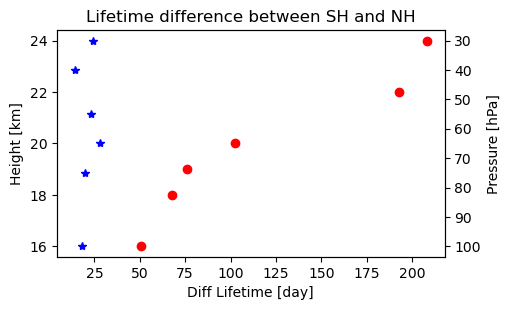

In [12]:

Diff_life_top = np.mean(Life_top_S, axis=1) - np.mean(Life_top_N, axis=1)
Diff_life = np.mean(Life_S, axis=1) - np.mean(Life_N, axis=1)


figure, ax1 = plt.subplots(figsize=(5,3), dpi=100)
ax2 = ax1.twinx()

ax1.plot(Diff_life_top, Height, 'ro', label='Total average')
ax1.set_ylabel("Height [km]")
ax1.set_xlabel("Diff Lifetime [day]")

ax2.plot(Diff_life, Pressure, 'b*', label="Top 10% average")
ax2.set_ylabel("Pressure [hPa]")
ax2.invert_yaxis()

ax1.set_title("Lifetime difference between SH and NH");

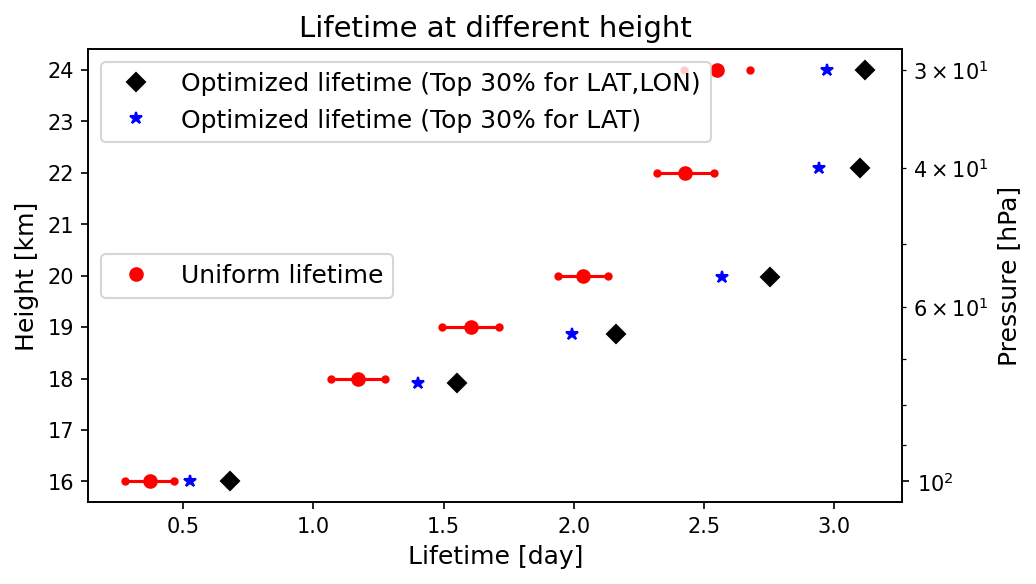

In [14]:
fig, ax1 = plt.subplots(figsize=(7,4), dpi=150)

###
ax1.plot( lifetime_mean/365.25, Height, 'ro', label='Uniform lifetime')
ax1.plot( (lifetime_mean+lifetime_std)/365.25, Height, 'r.')
ax1.plot( (lifetime_mean-lifetime_std)/365.25, Height, 'r.')

for i in range(5):
    ax1.plot( [(lifetime_mean[i]-lifetime_std[i])/365.25, (lifetime_mean[i]+lifetime_std[i])/365.25], 
             [Height[i], Height[i]], 'r-')
# print([lifetime_mean[0]-lifetime_std[0],lifetime_mean[0]-lifetime_std[0]])

ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Height [km]', fontsize=12)
ax1.legend(loc='center left', fontsize=12);

###
ax2 = ax1.twinx()
ax2.plot(Life_Z_TopMean/365.25, Pressure, 'kD', label='Optimized lifetime (Top 30% for LAT,LON)')
ax2.plot(Life_Z_top30_lat_mean/365.25, Pressure, 'b*', label='Optimized lifetime (Top 30% for LAT)')

ax2.set_ylabel('Pressure [hPa]', fontsize=12)
ax2.set_yscale('log')
ax2.invert_yaxis()
ax2.legend(loc="upper left", fontsize=12);


###
# ax3 = ax1.twinx()

# ax3.set_ylabel('Pressure [hPa]', fontsize=12)
# ax3.set_yscale('log')
# ax3.invert_yaxis()
# ax3.legend(loc="upper left", fontsize=12);


###
# ax3 = ax1.twinx()
# ax3.plot(Life_Z_top30_lat_lon_mean, Pressure, 'b^')

# ax3.set_ylabel('Pressure [hPa]', fontsize=12)
# ax3.set_yscale('log')
# ax3.invert_yaxis()
# ax3.legend(loc="upper left", fontsize=12);


plt.title('Lifetime at different height', fontsize=14);

In [13]:
(Life_Z_TopMean-lifetime_mean)/lifetime_mean

array([0.65453028, 0.33736641, 0.26252515, 0.1949335 , 0.17096334])

In [14]:
(lifetime_mean[4]-lifetime_mean[2])/4

37.692378564079945

In [15]:
Life_Z_TopMean

array([ 256.57203453,  757.66227477, 1271.74481982, 1352.41647898,
       1356.05994745])

In [16]:
Life_Z_TopMean

array([ 256.57203453,  757.66227477, 1271.74481982, 1352.41647898,
       1356.05994745])

(1) do the zonal mean, then select top 30% best injection latitude

(2) Inside the top 30% best injection latitude, select top 30% best inejction longitude for each best latitude

(3) plot lifeitme profile, including: 

    (a) total average lifetime;
    
    (b) average lifetime from top 30% injection latitude
    
    (c) average lifetime from top 30% injection longitude of top 30% injection latitude
    
    (d) average lifetime from top 9% injection location
